# Twin4Build: Building Space with Space Heater Example

This notebook demonstrates how to create and simulate a building space model with a space heater using Twin4Build. You'll learn how to:
1. Create a building space with thermal parameters
2. Set up a space heater with optimization capabilities
3. Configure various schedules (occupancy, temperature, solar radiation)
4. Connect components and create a complete building model
5. Optimize the space heater operation to maintain comfort while minimizing energy use

This example is particularly useful for understanding:
- How to model and control heating systems
- Thermal mass and insulation effects
- Occupancy patterns and comfort requirements
- Solar radiation impact
- Optimization of building control strategies

## 1. Setup
First, let's install and import the necessary packages. If you're running this in Google Colab, uncomment the pip install line.

In [1]:
# %pip install git+https://github.com/JBjoernskov/Twin4Build.git # Uncomment in google colab
import sys
import twin4build as tb
import datetime
from dateutil import tz


## 2. Create the Model

Let's create a new model instance. This will be our container for all the building components.

In [2]:
# Create a new model
model = tb.Model(id="optimizer_example")
print(model)

+---------------------------------------------------------------------------------------------------------------------------+
|                                          Model overview    id: optimizer_example                                          |
+---------------------------------------------+-----------------------------------------------------------------------------+
|  Number of components in simulation model:  |                                      0                                      |
+---------------------------------------------+-----------------------------------------------------------------------------+
| Number of connections in simulation model:  |                                      0                                      |
+---------------------------------------------+-----------------------------------------------------------------------------+
|              Model directory:               | C:\Users\jabj\AppData\Local\Temp\1\generated_files\models\optimizer_ex

C:\Users\jabj\Documents\python\Twin4Build\twin4build\utils\mkdir_in_root.py:10: MainPathNotFound: Could not determine main module path, using temp dir: C:\Users\jabj\AppData\Local\Temp\1
  current_dir = get_main_dir()


## 3. Create Building Components

Now we'll create the main building space component with its thermal parameters and the space heater component. The building space models:
- Thermal mass of air, walls, and interior elements
- Heat transfer through walls and boundaries
- Air infiltration and ventilation

The space heater models:
- Heat transfer from hot water to room air
- Thermal mass of the heater
- Variable water flow control

In [3]:
# Create a building space with thermal parameters
building_space = tb.BuildingSpaceThermalTorchSystem(
    C_air=2000000.0,
    C_wall=10000000.0,
    C_int=500000.0,
    C_boundary=800000.0,
    R_out=0.005,
    R_in=0.005,
    R_int=100000,
    R_boundary=10000,
    f_wall=0,
    f_air=0,
    Q_occ_gain=100.0,
    CO2_occ_gain=0.004,
    CO2_start=400.0,
    infiltrationRate=0.0,
    airVolume=100.0,
    id="BuildingSpace"
)

# Create space heater
space_heater = tb.SpaceHeaterTorchSystem(
    Q_flow_nominal_sh=2000.0,
    T_a_nominal_sh=60.0,
    T_b_nominal_sh=30.0,
    TAir_nominal_sh=21.0,
    thermalMassHeatCapacity=500000.0,
    nelements=3,
    id="SpaceHeater"
)

print("Building space component created:")
print(building_space)
print("\nSpace heater component created:")
print(space_heater)

Building space component created:
+---------------------------------------------+
|   Component overview    id: BuildingSpace   |
+-------------------------+-------------------+
|          input          |       output      |
+-------------------------+-------------------+
|    outdoorTemperature   | indoorTemperature |
|    supplyAirFlowRate    |  wallTemperature  |
|    exhaustAirFlowRate   |                   |
|   supplyAirTemperature  |                   |
|    globalIrradiation    |                   |
|      numberOfPeople     |                   |
|         heatGain        |                   |
|   boundaryTemperature   |                   |
| adjacentZoneTemperature |                   |
+-------------------------+-------------------+

Space heater component created:
+-------------------------------------------------+
|      Component overview    id: SpaceHeater      |
+------------------------+------------------------+
|         input          |         output         |
+----

## 4. Create Schedules

Now we'll create various schedules to control different aspects of the building:
1. Occupancy schedule - simulates people entering and leaving
2. Outdoor temperature schedule - simulates weather conditions
3. Solar radiation schedule - simulates solar heat gains
4. Supply air flow schedule - controls ventilation
5. Supply air temperature schedule - controls heating/cooling
6. Water flow schedule - controls space heater operation
7. Supply water temperature schedule - controls heating system
8. Heating and cooling setpoints - defines comfort requirements

In [4]:
# Create a schedule for occupancy
occupancy_schedule = tb.ScheduleSystem(
    weekDayRulesetDict={
        "ruleset_default_value": 0,
        "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_start_hour": [8, 9, 10, 12, 14, 16, 18],
        "ruleset_end_hour": [9, 10, 12, 14, 16, 18, 20],
        "ruleset_value": [0, 0, 0, 0, 0, 0, 0]
    },
    id="OccupancySchedule"
)

# Create an outdoor temperature profile
outdoor_temp = tb.ScheduleSystem(
    weekDayRulesetDict={
        "ruleset_default_value": 10.0,
        "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_start_hour": [0, 6, 12, 18, 21, 23, 24],
        "ruleset_end_hour": [6, 12, 18, 21, 23, 24, 24],
        "ruleset_value": [5.0, 8.0, 15.0, 12.0, 8.0, 5.0, 5.0]
    },
    id="OutdoorTemperature"
)

# Create a solar radiation profile
solar_radiation = tb.ScheduleSystem(
    weekDayRulesetDict={
        "ruleset_default_value": 0.0,
        "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_start_hour": [0, 6, 9, 12, 15, 18, 24],
        "ruleset_end_hour": [6, 9, 12, 15, 18, 24, 24],
        "ruleset_value": [0.0, 100, 300, 300, 100, 0.0, 0.0]
    },
    id="SolarRadiation"
)

# Create supply and exhaust air flow schedules
supply_air_flow = tb.ScheduleSystem(
    weekDayRulesetDict={"ruleset_default_value": 0.0},
    id="SupplyAirFlow"
)
exhaust_air_flow = tb.ScheduleSystem(
    weekDayRulesetDict={"ruleset_default_value": 0.0},
    id="ExhaustAirFlow"
)

# Create a supply air temperature schedule
supply_air_temp = tb.ScheduleSystem(
    weekDayRulesetDict={
        "ruleset_default_value": 20.0,
        "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_start_hour": [0, 8, 16, 0, 0, 0, 0],
        "ruleset_end_hour": [8, 16, 24, 0, 0, 0, 0],
        "ruleset_value": [0, 0, 0, 0.0, 0.0, 0.0, 0.0]
    },
    id="SupplyAirTemperature"
)

# Calculate nominal water flow rate
mf = space_heater.Q_flow_nominal_sh/4180/(space_heater.T_a_nominal_sh-space_heater.T_b_nominal_sh)

# Create water flow schedule
waterflow_schedule = tb.ScheduleSystem(
    weekDayRulesetDict = {
        "ruleset_default_value": 0,
        "ruleset_start_minute": [0,0],
        "ruleset_end_minute": [0,0],
        "ruleset_start_hour": [8, 19],
        "ruleset_end_hour": [16, 20],
        "ruleset_value": [mf, mf]
    },
    id="WaterflowSchedule"
)

# Create supply water temperature schedule
supply_temp = tb.ScheduleSystem(
    weekDayRulesetDict={
        "ruleset_default_value": 60.0,
        "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_start_hour": [0, 8, 16, 0, 0, 0, 0],
        "ruleset_end_hour": [8, 16, 24, 0, 0, 0, 0],
        "ruleset_value": [60, 60, 60, 60, 60, 60, 60]
    },
    id="SupplyTempSchedule"
)

# Create heating and cooling setpoints
heating_setpoint = tb.ScheduleSystem(
    weekDayRulesetDict={
        "ruleset_default_value": 18.0,
        "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_start_hour": [0, 8, 17, 0, 0, 0, 0],
        "ruleset_end_hour": [8, 16, 24, 0, 0, 0, 0],
        "ruleset_value": [18.0, 21.0, 18.0, 18.0, 18.0, 18.0, 18.0]
    },
    weekendRulesetDict={
        "ruleset_default_value": 0,
        "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_start_hour": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_end_hour": [0, 0, 0, 0, 0, 0, 0],
    },
    id="HeatingSetpoint"
)

cooling_setpoint = tb.ScheduleSystem(
    weekDayRulesetDict={
        "ruleset_default_value": 26.0,
        "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_start_hour": [0, 8, 17, 0, 0, 0, 0],
        "ruleset_end_hour": [8, 17, 24, 0, 0, 0, 0],
        "ruleset_value": [26.0, 24.0, 30.0, 26.0, 26.0, 26.0, 26.0]
    },
    id="CoolingSetpoint"
)

## 5. Connect Components

Now we'll connect all the components together to create our complete building model. This includes:
1. Connecting schedules to the building space
2. Connecting schedules to the space heater
3. Connecting the building space to the space heater
4. Connecting the space heater back to the building space

In [5]:
# Connect schedules to building space
model.add_connection(occupancy_schedule, building_space, "scheduleValue", "numberOfPeople")
model.add_connection(outdoor_temp, building_space, "scheduleValue", "outdoorTemperature")
model.add_connection(solar_radiation, building_space, "scheduleValue", "globalIrradiation")
model.add_connection(supply_air_flow, building_space, "scheduleValue", "supplyAirFlowRate")
model.add_connection(exhaust_air_flow, building_space, "scheduleValue", "exhaustAirFlowRate")
model.add_connection(supply_air_temp, building_space, "scheduleValue", "supplyAirTemperature")

# Connect schedules to space heater
model.add_connection(supply_temp, space_heater, "scheduleValue", "supplyWaterTemperature")
model.add_connection(waterflow_schedule, space_heater, "scheduleValue", "waterFlowRate")

# Connect building space indoorTemperature to space heater input
model.add_connection(building_space, space_heater, "indoorTemperature", "indoorTemperature")

# Connect space heater output to building space input
model.add_connection(space_heater, building_space, "Power", "heatGain")

# Load the model
model.load()


Loading model...[OK]
   |___Loading simulation model...[OK]
   |   |
   |   |___Removing cycles...[OK]
   |   |___Determining execution order...[OK]
   |   |___Loading parameters...[OK]
   |   |   |
   |   |
   |   |___Validating model...[WARNING]
   |   |   |
   |   |   |___|CLASS: BuildingSpaceThermalTorchSystem|ID: BuildingSpace|: Missing connections for the following input(s) to enable use of Simulator, Estimator, and Optimizer:
   |   |   |   |
   |   |   |   |___boundaryTemperature
   |   |   |   |___adjacentZoneTemperature
   |   |   |
   |   |
   |   |___Validated for Simulator...FAILED
   |   |___Validated for Estimator...FAILED
   |   |___Validated for Optimizer...FAILED
   |   |___
   |
   |___Drawing simulation model...
[OK]

Model loaded...

## 6. Run Initial Simulation

Let's run an initial simulation to see how the building performs with the default settings. This will help us understand the baseline performance before optimization.

100%|██████████| 216/216 [00:00<00:00, 1201.10it/s]


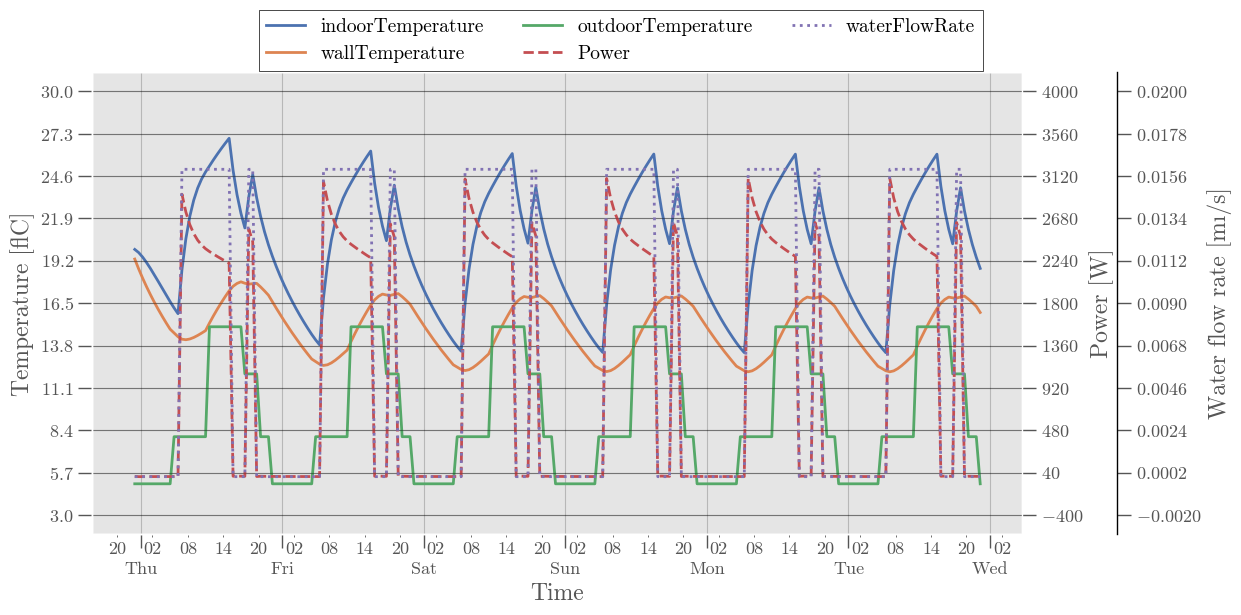

In [6]:
# Set up simulation parameters
simulator = tb.Simulator(model)
stepSize = 2400  # 40 minutes in seconds
startTime = datetime.datetime(
    year=2024, month=1, day=4, hour=0, minute=0, second=0,
    tzinfo=tz.gettz("Europe/Copenhagen")
)
endTime = datetime.datetime(
    year=2024, month=1, day=10, hour=0, minute=0, second=0,
    tzinfo=tz.gettz("Europe/Copenhagen")
)

# Run simulation
simulator.simulate(
    stepSize=stepSize,
    startTime=startTime,
    endTime=endTime
)

# Plot initial results
fig, axes = tb.plot.plot_component(
    simulator,
    components_1axis=[
        ("BuildingSpace", "indoorTemperature", "output"),
        ("BuildingSpace", "wallTemperature", "output"),
        ("BuildingSpace", "outdoorTemperature", "input"),
    ],
    components_2axis=[
        ("SpaceHeater", "Power", "output"),
    ],
    components_3axis=[
        ("SpaceHeater", "waterFlowRate", "input"),
    ],
    ylabel_1axis="Temperature [°C]",
    ylabel_2axis="Power [W]",
    ylabel_3axis="Water flow rate [m³/s]",
    show=True,
    nticks=11
)

## 7. Optimize Space Heater Operation

Now we'll optimize the space heater operation to maintain comfort while minimizing energy use. We'll:
1. Define optimization targets (minimize power consumption)
2. Set comfort constraints (temperature between heating and cooling setpoints)
3. Define decision variables (water flow rate)
4. Run the optimization with a learning rate scheduler

In [7]:
# Define optimization targets
variables = [
    (waterflow_schedule, "scheduleValue", 0, mf)  # Change water flow rate
]

objectives = [
    (space_heater, "Power", "min")  # Minimize power consumption
]

inequalityConstraints = [
    (building_space, "indoorTemperature", "upper", cooling_setpoint),  # Temperature should not exceed cooling setpoint
    (building_space, "indoorTemperature", "lower", heating_setpoint)   # Temperature should not fall below heating setpoint
]

# Create optimizer
optimizer = tb.Optimizer(simulator)

# # Run optimization with Torch solver
# options = {
#     "lr": 1.0,
#     "iterations": 400,
#     "optimizer_type": "SGD",
#     "scheduler_type": "reduce_on_plateau",
# }
# optimizer.optimize(
#     variables=variables,
#     objectives=objectives,
#     equalityConstraints=None,
#     inequalityConstraints=inequalityConstraints,
#     startTime=startTime,
#     endTime=endTime,
#     stepSize=stepSize,
#     method="torch",
#     options=options
# )




# Run optimization with Scipy solver
# On a normal laptop cpu, this takes around 2 minutes
options = {
    "maxiter": 150,
    "disp": True
}
optimizer.optimize(
    variables=variables,
    objectives=objectives,
    equalityConstraints=None,
    inequalityConstraints=inequalityConstraints,
    startTime=startTime,
    endTime=endTime,
    stepSize=stepSize,
    method="scipy",
    options=options
)







Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.22319202749347
            Iterations: 120
            Function evaluations: 307
            Gradient evaluations: 120


## 8. Plot Optimization Results

Finally, let's plot the results of our optimization to see how the building performs with the optimized space heater operation. We'll compare:
1. Indoor temperature vs. comfort setpoints
2. Space heater power consumption
3. Water flow rate

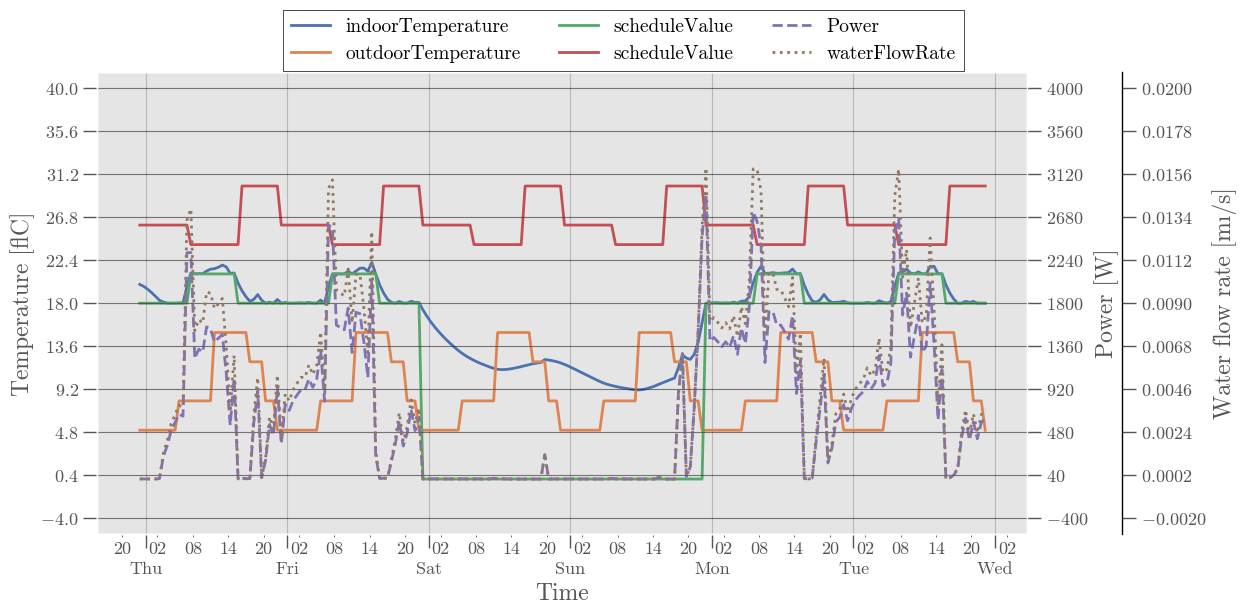

In [8]:
# Add setpoints to model for plotting
model.add_component(cooling_setpoint)
model.add_component(heating_setpoint)

# Plot optimization results
fig, axes = tb.plot.plot_component(
    simulator,
    components_1axis=[
        ("BuildingSpace", "indoorTemperature", "output"),
        ("BuildingSpace", "outdoorTemperature", "input"),
        ("HeatingSetpoint", "scheduleValue", "output"),
        ("CoolingSetpoint", "scheduleValue", "output"),
    ],
    components_2axis=[
        ("SpaceHeater", "Power", "output"),
    ],
    components_3axis=[
        ("SpaceHeater", "waterFlowRate", "input"),
    ],
    ylabel_1axis="Temperature [°C]",
    ylabel_2axis="Power [W]",
    ylabel_3axis="Water flow rate [m³/s]",
    show=True,
    nticks=11
)